In [5]:
# 必要なパッケージを呼び出す
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import japanize_matplotlib
import time

In [6]:
# MATLABではグローバル変数を使って関数への変数受け渡しを行う
# Julia/Pythonではコンストラクタを用いる

# ギリシャ文字の使用は不可とする
class Model:

    def __init__(self,alpha,beta,delta,Abar,kss,css,T):

        # カリブレーション
        self.alpha = alpha 
        self.beta = beta           
        self.delta = delta 
        self.Abar = Abar

        # 定常状態の値
        self.kss = kss
        self.css = css    
    
        # 移行過程に関する変数
        self.T = T

In [7]:
def shooting(m,c0,k0):
    """
    ------------------------------------------------------
    === ためし打ち法において、消費と資本の流列を求める関数 ===
    ------------------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・c0: 消費の初期値
    ・k0: 資本の初期値
    <output>
    ・k: 資本の流列
    ・c: 消費の流列
    """

    k = np.zeros(m.T+1)
    c = np.zeros(m.T+1)

    k[0] = k0
    c[0] = c0

    for t in range(m.T):

        k[t+1] = max(m.Abar*k[t]**m.alpha + (1-m.delta)*k[t] - c[t], 1e-4) # k>0
        c[t+1] = m.beta*c[t]*(1 + m.Abar*m.alpha*k[t+1]**(m.alpha-1) - m.delta)
    
    return k, c

In [8]:
def shooting_err(m,c0,k0):
    """
    --------------------------------------------------------------
    === ためし打ち法において、資本の定常状態とk_{T}の差を求める関数 ===
    --------------------------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・c0: 消費の初期値
    ・k0: 資本の初期値
    <output>
    ・err: 資本の定常状態とk_{T}の差
    """

    k, c = shooting(m,c0,k0)
    err = k[m.T-1] - m.kss

    return err

In [9]:
# カリブレーション
alpha = 0.4
beta = 0.96
delta = 1.0 
Abar = 1.0

# 定常状態の値
kss = (alpha*beta*Abar/(1-beta*(1-delta)))**(1/(1-alpha))
css = kss**alpha - delta*kss

# 移行過程に関する変数
T = 30

# k の初期値
k0 = 0.1

####  1. using root_scalar

In [10]:
tolfun = 1e-20 # 最適化の許容誤差

m = Model(alpha,beta,delta,Abar,kss,css,T)
c0 = root_scalar(lambda x: shooting_err(m,x,k0),bracket=[0.0,10.0],xtol=tolfun).root

k,c = shooting(m,c0,k0)

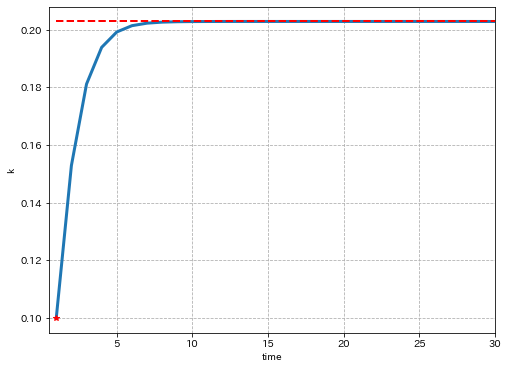

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1,m.T+1),k[0:m.T],lw=3)
ax.plot([1.0],[k[0]],c="r",marker="*")
ax.plot([1,100],[m.kss,m.kss],c="red",ls="--",lw=2)
ax.set(xlabel="time",ylabel="k",xlim=(0.5,m.T))
ax.grid(ls="--")
plt.show()

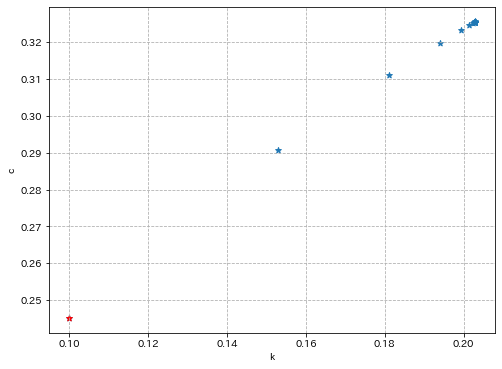

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(k,c,marker="*")
ax.scatter(k[0],c[0],marker="*",c="r")
ax.set(xlabel="k",ylabel="c")
ax.grid(ls="--")
plt.show()

#### 2.bisection

In [13]:
# 2. bisection
cL = 0.20
cH = 0.30
it = 1
maxit = 1000
dif = 1e+4

while (dif > 1e-15) & (it < maxit):

    c0 = (cL+cH)/2
    k,c = shooting(m,c0,k0)
    err = k[m.T] - m.kss

    if err > 0:
        cL = np.copy(c0)
    else:
        cH = np.copy(c0)
    
    #print([it,err])
    it += 1

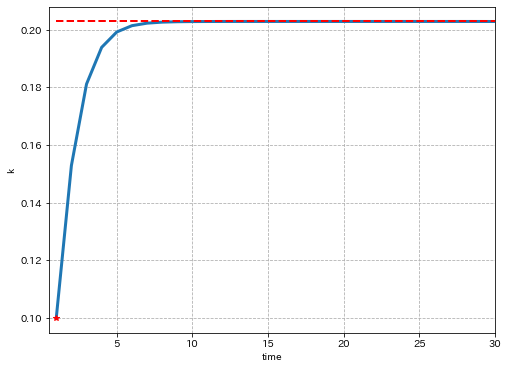

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1,m.T+1),k[0:m.T],lw=3)
ax.plot([1.0],[k[0]],c="r",marker="*")
ax.plot([1,100],[m.kss,m.kss],c="red",ls="--",lw=2)
ax.set(xlabel="time",ylabel="k",xlim=(0.5,m.T))
ax.grid(ls="--")
plt.show()

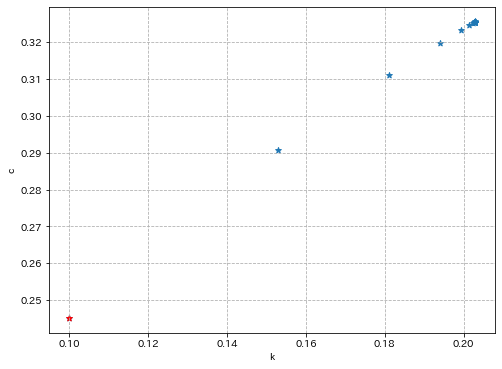

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(k,c,marker="*")
ax.scatter(k[0],c[0],marker="*",c="r")
ax.set(xlabel="k",ylabel="c")
ax.grid(ls="--")
plt.show()